# Librerias

In [50]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from six import StringIO
import pydotplus
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import joblib
import warnings
import os

# Warnings

In [51]:
warnings.filterwarnings('always')

# Datasets

In [52]:
ruta_hotels_train = os.path.join("..", "..", "Datasets", "hotels_train.csv")
ruta_hotels_test = os.path.join("..", "..", "Datasets", "hotels_test.csv")
ds_hotels_train = pd.read_csv(ruta_hotels_train)
ds_hotels_test = pd.read_csv(ruta_hotels_test)
df_hotels_train = ds_hotels_train.copy()
df_hotels_test = ds_hotels_test.copy()

Guardo "id"

In [53]:
s_id = df_hotels_test.pop("id")

# Preprocesamiento

In [54]:
print(df_hotels_train.shape)
print(df_hotels_test.shape)

(59626, 60)
(26535, 59)


Verifico balanceo

In [55]:
df_hotels_train["is_canceled"].value_counts(normalize=True)

is_canceled
1    0.503891
0    0.496109
Name: proportion, dtype: float64

In [56]:
features = list(df_hotels_train.columns)
features.remove("is_canceled")

Separo set de evaluacion

In [57]:
x_train, x_test, y_train, y_test = train_test_split(df_hotels_train[features].values, 
                                                    df_hotels_train["is_canceled"].values, 
                                                    test_size=0.2, random_state=42, 
                                                    stratify=df_hotels_train["is_canceled"].values)

Verifico la cantiad de datos en cada set

In [58]:
print("Datos Entrenamiento: {}".format(len(x_train)))
print("Datos Prueba: {}".format(len(x_test)))

Datos Entrenamiento: 47700
Datos Prueba: 11926


Verifico como quedaron balanceados

In [59]:
for split_name, split in zip(["% Positivos Entrenamiento","% Positivos Prueba"],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1] * 100))

% Positivos Entrenamiento: 50.390
% Positivos Prueba: 50.386


# AdaBoost - Adaptative Boosting

Construyo el modelo y lo entreno

In [60]:
ab_model = AdaBoostClassifier(n_estimators=10, random_state=0)
ab_model.fit(x_train, y_train)

AdaBoostClassifier(n_estimators=10, random_state=0)

Grafico el primer STUMP

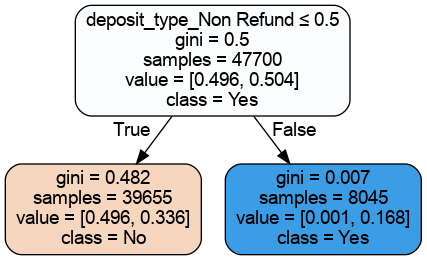

In [61]:
dot_data = StringIO()
export_graphviz(ab_model.estimators_[0],
                out_file=dot_data, filled=True,
                rounded=True,
                special_characters=True,
                feature_names=features,
                class_names=['No','Yes'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### Evalúo en el set de test

AUC

In [62]:
y_pred_proba = ab_model.predict_proba(x_test)[:, 1]
print ('AUC:', roc_auc_score(y_test, y_pred_proba))

AUC: 0.8850024495677193


Matriz Confusión

Text(50.722222222222214, 0.5, 'True')

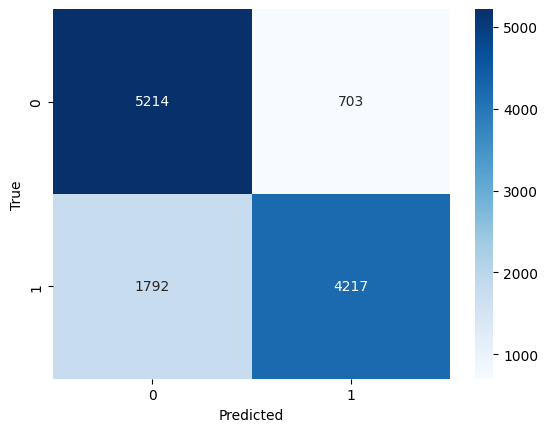

In [63]:
y_pred = ab_model.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Reporte

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.88      0.81      5917
           1       0.86      0.70      0.77      6009

    accuracy                           0.79     11926
   macro avg       0.80      0.79      0.79     11926
weighted avg       0.80      0.79      0.79     11926



## Exportacion csv

In [65]:
joblib.dump(ab_model, 'ada_boost.joblib')

['ada_boost.joblib']

In [66]:
y_pred = ab_model.predict(df_hotels_test)
df_summision = pd.DataFrame({'id': s_id, 'is_canceled': y_pred})

/home/martin/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


In [67]:
df_summision.to_csv('ada_boost.csv', index = False)

# Gradient Boosting

Construyo el modelo y lo entreno

In [68]:
gb_model = GradientBoostingClassifier(random_state=17)
gb_model.fit(x_train, y_train)

GradientBoostingClassifier(random_state=17)

Grafico el primer árbol 

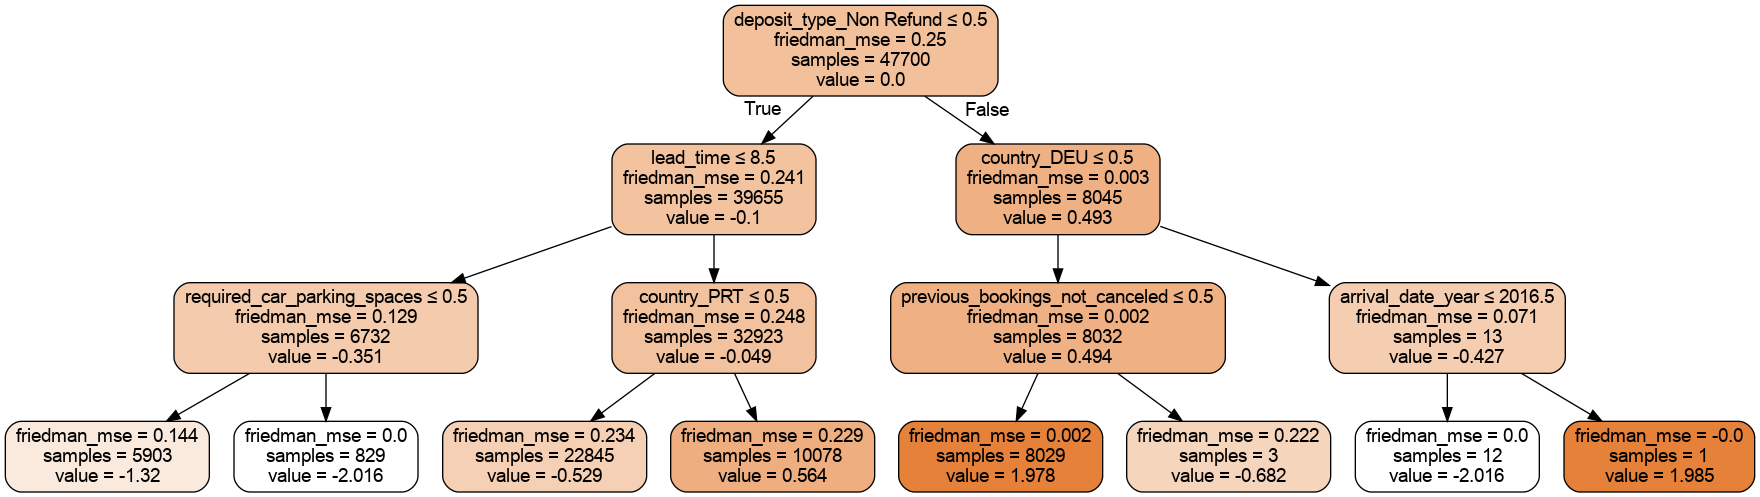

In [69]:
dot_data = StringIO()
export_graphviz(gb_model.estimators_[0][0],
                out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### Evalúo en el set de test

AUC

In [70]:
y_pred_proba = gb_model.predict_proba(x_test)[:, 1]
print('AUC:',roc_auc_score(y_test, y_pred_proba))

AUC: 0.9281650590420494


Matriz de Confusión

In [71]:
y_pred = gb_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

Arbol Reporte y Matriz de Confusion

In [72]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      5917
           1       0.84      0.84      0.84      6009

    accuracy                           0.84     11926
   macro avg       0.84      0.84      0.84     11926
weighted avg       0.84      0.84      0.84     11926



Parámetros a optimizar

In [73]:
params_grid = {'n_estimators':range(20, 150, 5), 'max_depth': range(1, 7), 'learning_rate': np.arange(0, 1, 0.001)}

Folds

In [74]:
kfoldcv = StratifiedKFold(n_splits=5)

Ramdom Search CV

In [75]:
randomcv = RandomizedSearchCV(GradientBoostingClassifier(), params_grid, n_jobs=10, scoring='roc_auc',cv=kfoldcv, n_iter=10)
randomcv.fit(x_train, y_train)
print (randomcv.best_score_, randomcv.best_params_)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

0.9431177746684266 {'n_estimators': 85, 'max_depth': 6, 'learning_rate': 0.426}


Mejor Modelo

In [76]:
gb = randomcv.best_estimator_

Evalúo en el set de train

In [77]:
y_pred_proba= gb.predict_proba(x_train)[:, 1]
print('AUC:',roc_auc_score(y_train, y_pred_proba))

AUC: 0.9778030204031907


#### Evalúo en el set de test

AUC

In [78]:
y_pred_proba= gb.predict_proba(x_test)[:, 1]
print('AUC:', roc_auc_score(y_test, y_pred_proba))

AUC: 0.9463544950727816


Matriz de Confusión

In [79]:
y_pred = gb.predict(x_test)
cm = confusion_matrix(y_test,y_pred)

Reporte

In [80]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      5917
           1       0.86      0.88      0.87      6009

    accuracy                           0.87     11926
   macro avg       0.87      0.87      0.87     11926
weighted avg       0.87      0.87      0.87     11926



## Exportacion CSV

In [81]:
joblib.dump(gb_model, 'gradient_boosting.joblib')

['gradient_boosting.joblib']

In [82]:
y_pred = gb_model.predict(df_hotels_test)
df_summision = pd.DataFrame({'id': s_id, 'is_canceled': y_pred})

/home/martin/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [83]:
df_summision.to_csv('gradient_boosting.csv', index = False)

# XGBoost - Extreme Gradient Boosting

Creo el modelo y lo entreno

In [84]:
xgb_model = xgb.XGBClassifier(max_depth=15,
                              learning_rate=0.1,
                              n_estimators=100,
                              subsambple=0.1,
                              colsample_bytree=0.8,
                              gamma=0.1,
                              objective="binary:logistic",
                              random_state=42)

xgb_model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:08:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "subsambple" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Evaluo en el set de test

In [85]:
y_pred_proba= xgb_model.predict_proba(x_test)[:, 1]
print('AUC:',roc_auc_score(y_test, y_pred_proba))

AUC: 0.9572593534913112


Matriz de Confusion

Text(50.722222222222214, 0.5, 'True')

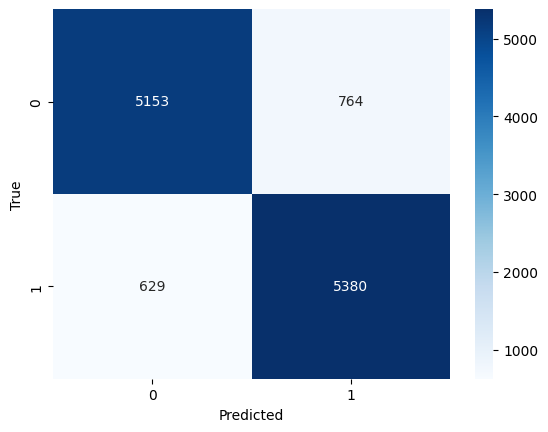

In [86]:
y_pred = xgb_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Reporte

In [87]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      5917
           1       0.88      0.90      0.89      6009

    accuracy                           0.88     11926
   macro avg       0.88      0.88      0.88     11926
weighted avg       0.88      0.88      0.88     11926



Datos de entrenamiento en formato DMatrix

In [88]:
data_dmatrix = xgb.DMatrix(data=x_train, label=y_train)

Entreno CV para probar el learning rate

In [89]:
results = xgb.cv(dtrain=data_dmatrix, nfold=5, params={'learning_rate':0.1}, num_boost_round=8, metrics='auc')
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.891501,0.000766,0.890172,0.003225
1,0.898160,0.001254,0.896583,0.002592
2,0.900988,0.000569,0.899435,0.003024
3,0.902612,0.000786,0.901020,0.003058
4,0.905371,0.000787,0.903643,0.003080
5,0.906916,0.001416,0.905162,0.001659
6,0.909209,0.000752,0.907525,0.002881
7,0.911089,0.000944,0.909359,0.002514


Entreno CV para probar el learning rate mas alto

In [90]:
results = xgb.cv(dtrain=data_dmatrix, nfold=10, params={'learning_rate':0.2}, num_boost_round=100, metrics='auc', seed=42)
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.891294,0.000504,0.890006,0.004355
1,0.900201,0.000559,0.898777,0.004963
2,0.904496,0.001163,0.902692,0.004840
3,0.909515,0.001532,0.907649,0.005293
4,0.911808,0.001976,0.910008,0.004641
...,...,...,...,...
95,0.963424,0.000596,0.942812,0.002693
96,0.963632,0.000628,0.942827,0.002666
97,0.963821,0.000622,0.942897,0.002655
98,0.964020,0.000578,0.942981,0.002682


## Exportacion CSV

In [91]:
y_pred_s = xgb_model.predict(df_hotels_test)
df_summision = pd.DataFrame({'id': s_id, 'is_canceled': y_pred_s})

/usr/local/lib/python3.10/dist-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/usr/local/lib/python3.10/dist-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/usr/local/lib/python3.10/dist-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/usr/local/lib/python3.10/dist-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/usr/local/lib/python3.10/dist-pac

In [92]:
#joblib.dump(xgb_model, 'xgboost.joblib')

In [93]:
#y_pred = xgb_model.predict(df_hotels_test)
#df_summision = pd.DataFrame({'id': s_id, 'is_canceled': y_pred})

In [94]:
df_summision.to_csv('xgboost.csv', index=False)